In [1]:
!pip install -U seaborn-image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import joblib
import seaborn_image as isns 
import cv2

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPool2D,
    MaxPooling2D,
    Input
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Data overview

In [2]:
data_train = pd.read_csv('data/fashion-mnist_train.csv')
data_test = pd.read_csv('data/fashion-mnist_test.csv')

In [3]:
data_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X = data_train.drop(['label'], axis=1)
y = data_train['label']

X_test = data_test.drop(['label'], axis=1)
y_test = data_test['label']

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 358.9 MB


Labels :

* 0 - T-shirt/top
* 1 - Trouser
* 2 - Pullover
* 3 - Dress
* 4 - Coat
* 5 - Sandals
* 6 - Shirt
* 7 - Sneaker
* 8 - Bag
* 9 - Ankle Boots

In [6]:
X = X.to_numpy()
y = y.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

<Axes: >

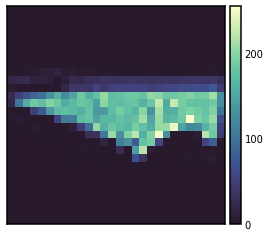

In [7]:
rand_number = np.random.randint(0,60000)
example = X[rand_number].reshape(28,28)
isns.imgplot(example)

As we can see, all the images are upside down, so we need to flip them back by 180 degree.

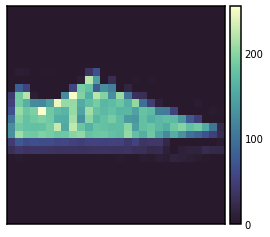

In [8]:
example = X[rand_number][::-1].reshape(28,28)
isns.imgplot(example)
plt.savefig('images/example.png')

Now the images look as they should. Let's rotate all the images.

In [9]:
X = np.array([i[::-1] for i in X])
X_test = np.array([i[::-1] for i in X_test])

<Axes: >

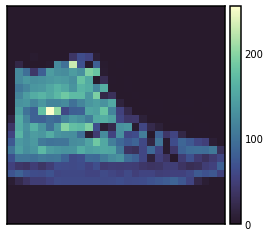

In [10]:
rand_number = np.random.randint(0,60000)
example = X[rand_number].reshape(28,28)
isns.imgplot(example)

In [11]:
indices = []

while len(indices)<10:
    index = np.random.randint(0,60000)
    if index not in indices:
        indices.append(index)

a = 0
fig, ax = plt.subplots(5,2,figsize=(20,30),dpi=1200)
for i in range(10):
    r=i//2
    c=i%2
    isns.imgplot(X[indices[a]].reshape(28,28),ax=ax[r,c])
    a+=1
    
plt.savefig('images/sample_images.png')

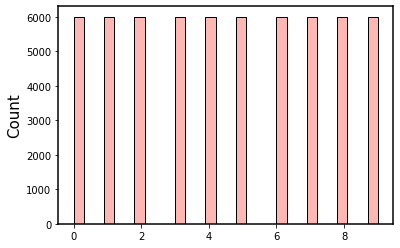

In [12]:
sns.histplot(y, label='Classes', color='#ff9f9b',bins=30)
plt.savefig('images/classes_histplot.png')

#Data preparation

In [13]:
X = (X / 255.0).reshape(X.shape[0], 28, 28, 1)
X_test = (X_test / 255.0).reshape(X_test.shape[0], 28, 28, 1)

In [14]:
val_split = 0.25
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, stratify=y)

In [15]:
print(X_train.shape)
print(y_train.shape)

(45000, 28, 28, 1)
(45000,)


In [16]:
print(np.unique(y_train))
print(np.unique(y_val))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [17]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

#Neural Network

We will first train the standard ANN for better comparison.

In [18]:
model = Sequential()

model.add(Input(shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In [20]:
optimizer = Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,)

In [21]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
epochs = 30
batch_size = 64

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [24]:
history = model.fit(X_train,y_train, batch_size=batch_size,
                              epochs = epochs, validation_data = (X_val, y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                               callbacks=[learning_rate_reduction])

Epoch 1/30
703/703 [==============================] - 7s 5ms/step - loss: 0.7151 - accuracy: 0.7406 - val_loss: 0.4536 - val_accuracy: 0.8323 - lr: 0.0010
Epoch 2/30
703/703 [==============================] - 3s 4ms/step - loss: 0.4960 - accuracy: 0.8254 - val_loss: 0.4226 - val_accuracy: 0.8411 - lr: 0.0010
Epoch 3/30
703/703 [==============================] - 3s 5ms/step - loss: 0.4513 - accuracy: 0.8403 - val_loss: 0.3883 - val_accuracy: 0.8554 - lr: 0.0010
Epoch 4/30
703/703 [==============================] - 3s 4ms/step - loss: 0.4240 - accuracy: 0.8500 - val_loss: 0.3705 - val_accuracy: 0.8652 - lr: 0.0010
Epoch 5/30
703/703 [==============================] - 4s 6ms/step - loss: 0.4022 - accuracy: 0.8578 - val_loss: 0.3484 - val_accuracy: 0.8727 - lr: 0.0010
Epoch 6/30
703/703 [==============================] - 4s 5ms/step - loss: 0.3889 - accuracy: 0.8615 - val_loss: 0.3593 - val_accuracy: 0.8684 - lr: 0.0010
Epoch 7/30
703/703 [==============================] - 4s 5ms/step - lo

In [25]:
history_dict = history.history

In [26]:
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


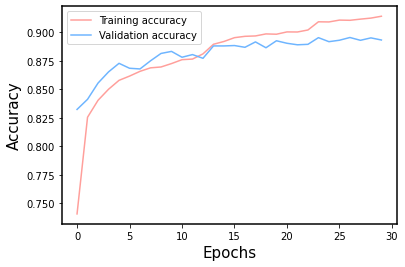

In [27]:
plt.plot(history_dict['accuracy'], label='Training accuracy', color='#ff9f9b')
plt.plot(history_dict['val_accuracy'], label='Validation accuracy', color='#6eb5ff')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('images/ANN_accuracy.png')
plt.show()

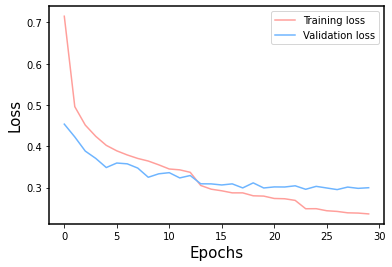

In [28]:
plt.plot(history_dict['loss'], label='Training loss', color='#ff9f9b')
plt.plot(history_dict['val_loss'], label='Validation loss', color='#6eb5ff')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('images/ANN_loss.png')
plt.show()

In [29]:
results = model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3024 - accuracy: 0.8959


In [30]:
print('Test Loss : {:.4f}'.format(results[0]))
print('Test Accuracy : {:.4f}'.format(results[1]))

Test Loss : 0.3024
Test Accuracy : 0.8959


In [31]:
ann_pred = model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [32]:
y_test_cm = np.argmax(y_test, axis=1)

In [33]:
ann_cm = confusion_matrix(y_test_cm, np.argmax(ann_pred, axis=1))

In [34]:
names = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

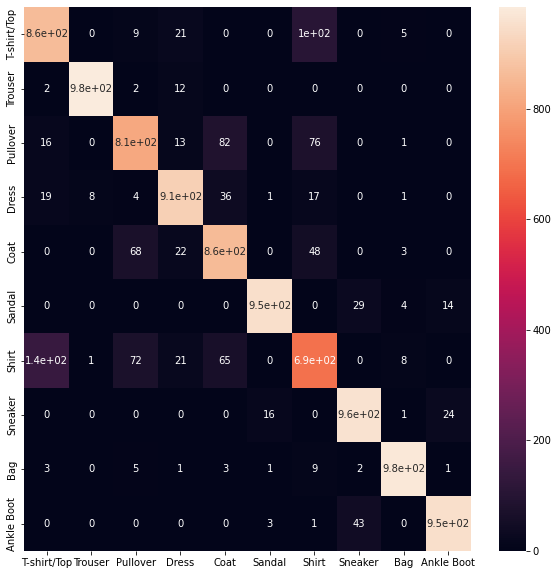

In [35]:
df_cm = pd.DataFrame(ann_cm, index = names,
                  columns = names)
plt.figure(figsize = (10,10))
ann_cm_heatmap = sns.heatmap(df_cm, annot=True)
plt.savefig('images/ANN_cm.png')

In [36]:
ann_pred = np.argmax(ann_pred, axis=1)

In [37]:
incorrect = []
while len(incorrect) < 4:
    randint = np.random.randint(0,len(ann_pred))
    if (ann_pred[randint] != y_test_cm[randint]) and (randint not in incorrect):
        incorrect.append(randint)

In [38]:
ann_incorrect = 0
for i in range(len(ann_pred)):
    if (ann_pred[i] != y_test_cm[i]):
        ann_incorrect += 1
print(ann_incorrect)

1041


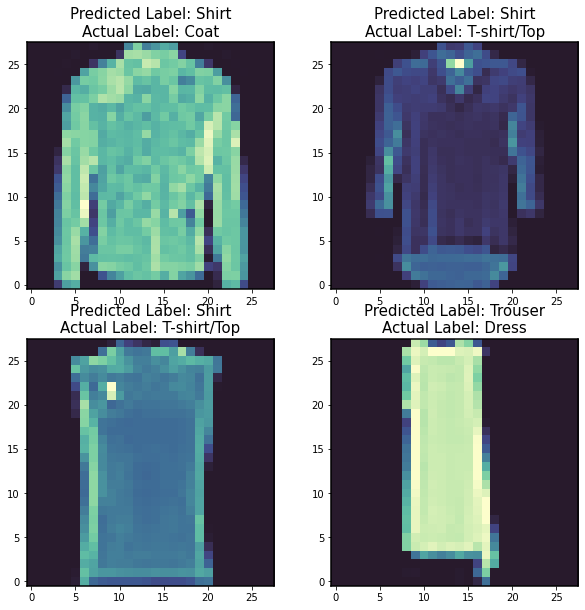

In [39]:
a = 0
fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.set_size_inches(10,10)
for i in range(4):
    r=i//2
    c=i%2
    ax[r,c].imshow(X_test[incorrect[a]].reshape(28,28))
    ax[r,c].set_title('Predicted Label: ' + names[ann_pred[incorrect[a]]] + '\n'+'Actual Label: ' + 
                 names[y_test_cm[incorrect[a]]])
    a+=1
plt.savefig('images/ANN_incorrect_pred.png')

In [40]:
model.save('models/ANN_Model')

#CNN

Training of standard CNN.

In [41]:
model_cnn = Sequential()

model_cnn.add(Input(shape=(28,28,1)))
model_cnn.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model_cnn.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model_cnn.add(MaxPool2D(pool_size=(2,2)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model_cnn.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model_cnn.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation = "relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(128, activation = "relu"))
model_cnn.add(Dropout(0.25))
model_cnn.add(Dense(10, activation = "softmax"))

In [42]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                      

In [43]:
model_cnn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [44]:
epochs = 30
batch_size = 64

In [45]:
history_cnn = model_cnn.fit(X_train,y_train, batch_size=batch_size,
                              epochs = epochs, validation_data = (X_val, y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                               callbacks=[learning_rate_reduction])

Epoch 1/30
703/703 [==============================] - 12s 10ms/step - loss: 0.7225 - accuracy: 0.7364 - val_loss: 0.4292 - val_accuracy: 0.8428 - lr: 1.2500e-04
Epoch 2/30
703/703 [==============================] - 10s 14ms/step - loss: 0.4832 - accuracy: 0.8258 - val_loss: 0.3625 - val_accuracy: 0.8652 - lr: 1.2500e-04
Epoch 3/30
703/703 [==============================] - 6s 8ms/step - loss: 0.4273 - accuracy: 0.8471 - val_loss: 0.3392 - val_accuracy: 0.8755 - lr: 1.2500e-04
Epoch 4/30
703/703 [==============================] - 6s 9ms/step - loss: 0.3898 - accuracy: 0.8592 - val_loss: 0.3147 - val_accuracy: 0.8807 - lr: 1.2500e-04
Epoch 5/30
703/703 [==============================] - 6s 8ms/step - loss: 0.3648 - accuracy: 0.8684 - val_loss: 0.2980 - val_accuracy: 0.8891 - lr: 1.2500e-04
Epoch 6/30
703/703 [==============================] - 6s 9ms/step - loss: 0.3465 - accuracy: 0.8745 - val_loss: 0.2856 - val_accuracy: 0.8955 - lr: 1.2500e-04
Epoch 7/30
703/703 [======================

In [46]:
history_dict_cnn = history_cnn.history

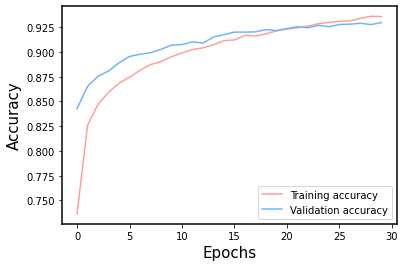

In [47]:
plt.plot(history_dict_cnn['accuracy'], label='Training accuracy', color='#ff9f9b')
plt.plot(history_dict_cnn['val_accuracy'], label='Validation accuracy', color='#6eb5ff')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('images/CNN_accuracy.png')
plt.show()

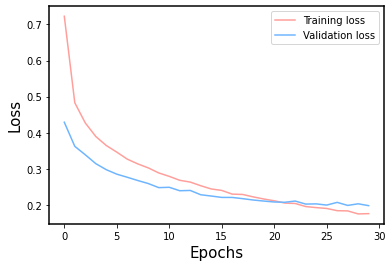

In [48]:
plt.plot(history_dict_cnn['loss'], label='Training loss', color='#ff9f9b')
plt.plot(history_dict_cnn['val_loss'], label='Validation loss', color='#6eb5ff')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('images/CNN_loss.png')
plt.show()

In [49]:
results_cnn = model_cnn.evaluate(X_test , y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.1922 - accuracy: 0.9287


In [50]:
print('Test Loss : {:.4f}'.format(results_cnn[0]))
print('Test Accuracy : {:.4f}'.format(results_cnn[1]))

Test Loss : 0.1922
Test Accuracy : 0.9287


In [51]:
cnn_pred = model_cnn.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [52]:
cnn_cm = confusion_matrix(y_test_cm, np.argmax(cnn_pred, axis=1))

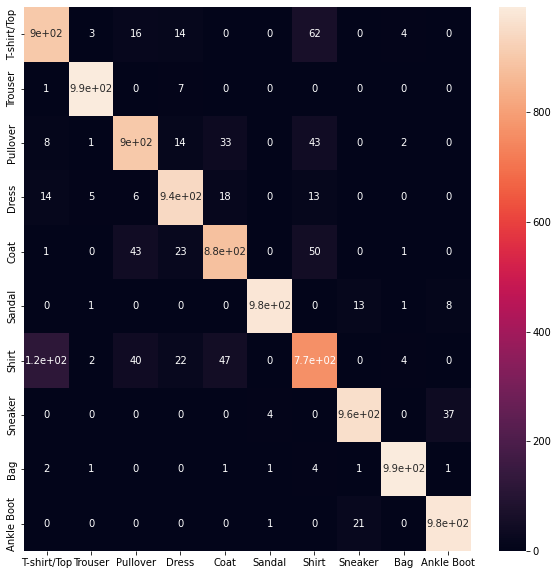

In [53]:
df_cm = pd.DataFrame(cnn_cm, index = names,
                  columns = names)
plt.figure(figsize = (10,10))
cnn_cm_heatmap = sns.heatmap(df_cm, annot=True)
plt.savefig('images/CNN_cm.png')

In [54]:
cnn_pred = np.argmax(cnn_pred, axis=1)

In [55]:
incorrect = []
while len(incorrect) < 4:
    randint = np.random.randint(0,len(cnn_pred))
    if (cnn_pred[randint] != y_test_cm[randint]) and (randint not in incorrect):
        incorrect.append(randint)

In [56]:
cnn_incorrect = 0
for i in range(len(cnn_pred)):
    if (cnn_pred[i] != y_test_cm[i]):
        cnn_incorrect += 1
print(cnn_incorrect)

713


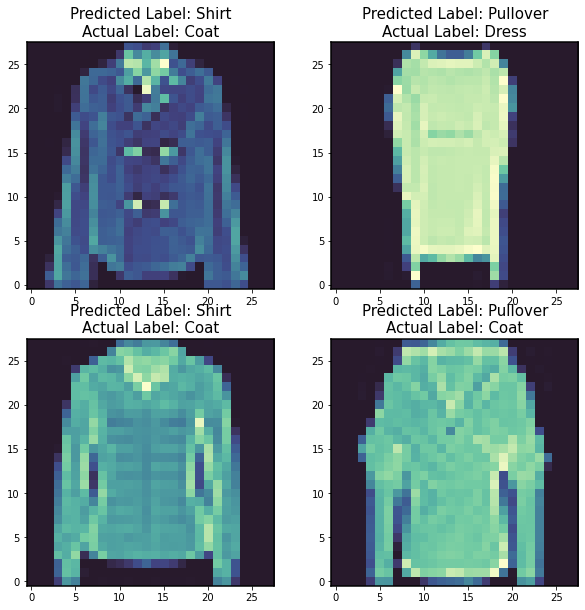

In [57]:
a = 0
fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.set_size_inches(10,10)
for i in range(4):
    r=i//2
    c=i%2
    ax[r,c].imshow(X_test[incorrect[a]].reshape(28,28))
    ax[r,c].set_title('Predicted Label: ' + names[cnn_pred[incorrect[a]]] + '\n'+'Actual Label: ' + 
                 names[y_test_cm[incorrect[a]]])
    a+=1
plt.savefig('images/CNN_incorrect_pred.png')

In [58]:
model_cnn.save('models/CNN_Model')

#CNN with datagenerator

In this case, we will train exactly the same model as the previous CNN, but the only difference will be the use of the Image Data Generator that in theory should give us better solution of problem due to 'more' data. 

In [59]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,
        horizontal_flip=False,  
        vertical_flip=True)


datagen.fit(X_train)

In [60]:
model_cnn2 = Sequential()

model_cnn2.add(Input(shape=(28,28,1)))
model_cnn2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model_cnn2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model_cnn2.add(MaxPool2D(pool_size=(2,2)))
model_cnn2.add(Dropout(0.25))
model_cnn2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model_cnn2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model_cnn2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_cnn2.add(Dropout(0.25))
model_cnn2.add(Flatten())
model_cnn2.add(Dense(256, activation = "relu"))
model_cnn2.add(Dropout(0.5))
model_cnn2.add(Dense(128, activation = "relu"))
model_cnn2.add(Dropout(0.25))
model_cnn2.add(Dense(10, activation = "softmax"))

In [141]:
model_cnn2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        36928     
                                                      

In [61]:
model_cnn2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [62]:
epochs = 30
batch_size = 64

In [63]:
history_cnn2 = model_cnn2.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                               callbacks=[learning_rate_reduction])

Epoch 1/30
703/703 [==============================] - 26s 35ms/step - loss: 1.0289 - accuracy: 0.6070 - val_loss: 0.6284 - val_accuracy: 0.7559 - lr: 1.2500e-04
Epoch 2/30
703/703 [==============================] - 20s 28ms/step - loss: 0.7598 - accuracy: 0.7107 - val_loss: 0.5663 - val_accuracy: 0.7775 - lr: 1.2500e-04
Epoch 3/30
703/703 [==============================] - 21s 29ms/step - loss: 0.6940 - accuracy: 0.7367 - val_loss: 0.5189 - val_accuracy: 0.7928 - lr: 1.2500e-04
Epoch 4/30
703/703 [==============================] - 20s 28ms/step - loss: 0.6512 - accuracy: 0.7508 - val_loss: 0.4880 - val_accuracy: 0.8065 - lr: 1.2500e-04
Epoch 5/30
703/703 [==============================] - 20s 28ms/step - loss: 0.6199 - accuracy: 0.7664 - val_loss: 0.4651 - val_accuracy: 0.8221 - lr: 1.2500e-04
Epoch 6/30
703/703 [==============================] - 20s 29ms/step - loss: 0.6006 - accuracy: 0.7721 - val_loss: 0.4465 - val_accuracy: 0.8331 - lr: 1.2500e-04
Epoch 7/30
703/703 [==============

In [77]:
history_dict_cnn2 = history_cnn2.history

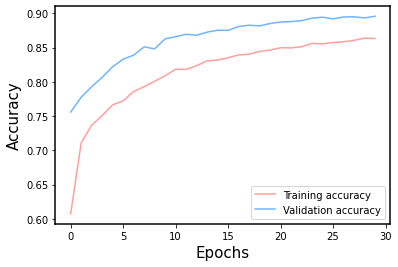

In [78]:
plt.plot(history_dict_cnn2['accuracy'], label='Training accuracy', color='#ff9f9b')
plt.plot(history_dict_cnn2['val_accuracy'], label='Validation accuracy', color='#6eb5ff')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('images/CNN2_accuracy.png')
plt.show()

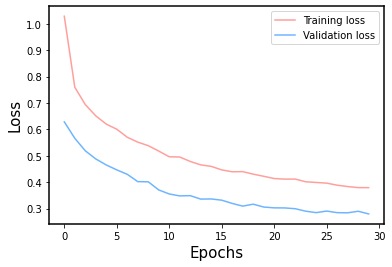

In [79]:
plt.plot(history_dict_cnn2['loss'], label='Training loss', color='#ff9f9b')
plt.plot(history_dict_cnn2['val_loss'], label='Validation loss', color='#6eb5ff')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('images/CNN2_loss.png')
plt.show()

In [80]:
results_cnn2 = model_cnn2.evaluate(X_test , y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.2698 - accuracy: 0.9011


In [81]:
print('Test Loss : {:.4f}'.format(results_cnn2[0]))
print('Test Accuracy : {:.4f}'.format(results_cnn2[1]))

Test Loss : 0.2698
Test Accuracy : 0.9011


In [82]:
cnn2_pred = model_cnn2.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [83]:
cnn2_cm = confusion_matrix(y_test_cm, np.argmax(cnn2_pred, axis=1))

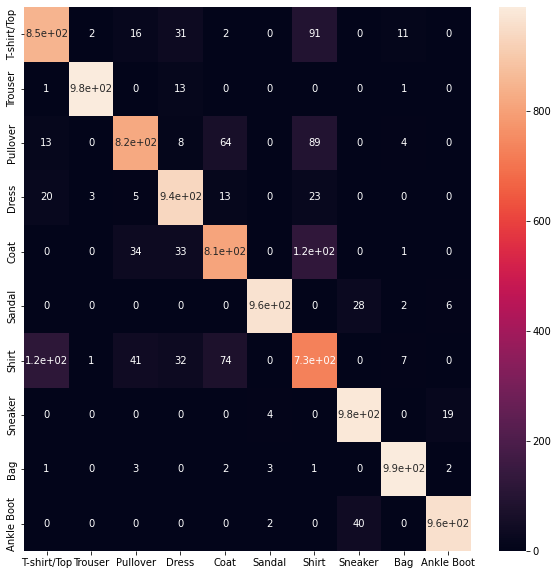

In [84]:
df_cm = pd.DataFrame(cnn2_cm, index = names,
                  columns = names)
plt.figure(figsize = (10,10))
cnn_cm_heatmap = sns.heatmap(df_cm, annot=True)
plt.savefig('images/CNN2_cm.png')

In [85]:
cnn2_pred = np.argmax(cnn2_pred, axis=1)

In [86]:
cnn2_incorrect = 0
for i in range(len(cnn2_pred)):
    if (cnn2_pred[i] != y_test_cm[i]):
        cnn2_incorrect += 1
print(cnn2_incorrect)

989


In [87]:
incorrect = []
while len(incorrect) < 4:
    randint = np.random.randint(0,len(cnn2_pred))
    if (cnn2_pred[randint] != y_test_cm[randint]) and (randint not in incorrect):
        incorrect.append(randint)

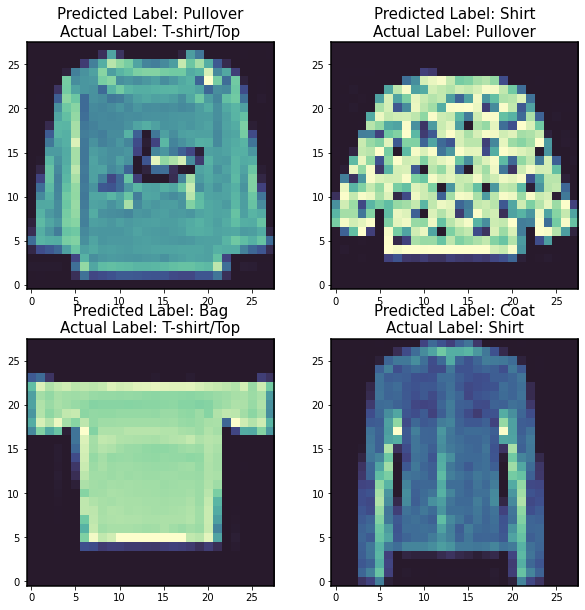

In [88]:
a = 0
fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.set_size_inches(10,10)
for i in range(4):
    r=i//2
    c=i%2
    ax[r,c].imshow(X_test[incorrect[a]].reshape(28,28))
    ax[r,c].set_title('Predicted Label: ' + names[cnn2_pred[incorrect[a]]] + '\n'+'Actual Label: ' + 
                 names[y_test_cm[incorrect[a]]])
    a+=1
plt.savefig('images/CNN2_incorrect_pred.png')

In [89]:
model_cnn2.save('models/CNN2_Model')

#Pretrained CNN

This model will be first trained on standard MNIST data and after that it will be trained again on Fashion MNIST data set. In theory after learning on MNIST data it's should be able to learn faster and betten Fashion MNIST data due to uniwersal paterns it should have after first training.

##Training CNN on MNIST data

Preparing MNIST data

In [90]:
MNIST = pd.read_csv('data/mnist_train.csv')
MNIST_test = pd.read_csv('data/mnist_test.csv') 

In [91]:
MNIST.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
MNIST_X = MNIST.drop(['label'], axis=1)
MNIST_y = MNIST['label']

MNIST_test_X = MNIST_test.drop(['label'], axis=1)
MNIST_test_y = MNIST_test['label']

In [93]:
MNIST_X = MNIST_X.to_numpy()
MNIST_y = MNIST_y.to_numpy()

MNIST_test_X = MNIST_test_X.to_numpy()
MNIST_test_y = MNIST_test_y.to_numpy()

In [94]:
MNIST_X = (MNIST_X/255).reshape(MNIST_X.shape[0], 28, 28, 1)
MNIST_test_X = (MNIST_test_X/255).reshape(MNIST_test_X.shape[0], 28, 28, 1)

In [95]:
MNIST_y = to_categorical(MNIST_y)
MNIST_test_y = to_categorical(MNIST_test_y)

In [96]:
MNIST_train_X, MNIST_val_X, MNIST_train_y, MNIST_val_y = train_test_split(MNIST_X, MNIST_y, test_size=0.2, random_state=42, stratify=MNIST_y)

Training model

In [97]:
model_cnn3 = Sequential()

model_cnn3.add(Input(shape=(28,28,1)))
model_cnn3.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model_cnn3.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model_cnn3.add(MaxPool2D(pool_size=(2,2)))
model_cnn3.add(Dropout(0.25))
model_cnn3.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model_cnn3.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model_cnn3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_cnn3.add(Dropout(0.25))
model_cnn3.add(Flatten())
model_cnn3.add(Dense(256, activation = "relu"))
model_cnn3.add(Dropout(0.5))
model_cnn3.add(Dense(128, activation = "relu"))
model_cnn3.add(Dropout(0.25))
model_cnn3.add(Dense(10, activation = "softmax"))

In [142]:
model_cnn3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        36928     
                                                      

In [98]:
model_cnn3.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [99]:
datagen2 = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,
        horizontal_flip=False,  
        vertical_flip=False)


datagen2.fit(MNIST_train_X)

In [100]:
epochs = 10
batch_size = 64

In [101]:
history_cnn3 = model_cnn3.fit(datagen2.flow(MNIST_train_X, MNIST_train_y, batch_size=batch_size),
                              epochs = epochs, validation_data = (MNIST_val_X, MNIST_val_y),
                              verbose = 1, steps_per_epoch=MNIST_train_X.shape[0] // batch_size,
                               callbacks=[learning_rate_reduction])

Epoch 1/10
750/750 [==============================] - 20s 26ms/step - loss: 0.5939 - accuracy: 0.8057 - val_loss: 0.0865 - val_accuracy: 0.9742 - lr: 1.2500e-04
Epoch 2/10
750/750 [==============================] - 20s 26ms/step - loss: 0.2215 - accuracy: 0.9351 - val_loss: 0.0651 - val_accuracy: 0.9822 - lr: 1.2500e-04
Epoch 3/10
750/750 [==============================] - 19s 26ms/step - loss: 0.1728 - accuracy: 0.9500 - val_loss: 0.0509 - val_accuracy: 0.9862 - lr: 1.2500e-04
Epoch 4/10
750/750 [==============================] - 21s 28ms/step - loss: 0.1448 - accuracy: 0.9581 - val_loss: 0.0434 - val_accuracy: 0.9875 - lr: 1.2500e-04
Epoch 5/10
750/750 [==============================] - 20s 27ms/step - loss: 0.1276 - accuracy: 0.9639 - val_loss: 0.0391 - val_accuracy: 0.9884 - lr: 1.2500e-04
Epoch 6/10
750/750 [==============================] - 19s 26ms/step - loss: 0.1125 - accuracy: 0.9678 - val_loss: 0.0434 - val_accuracy: 0.9870 - lr: 1.2500e-04
Epoch 7/10
750/750 [==============

In [106]:
history_dict_cnn3 = history_cnn3.history

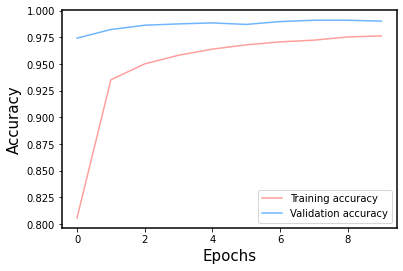

In [114]:
plt.plot(history_dict_cnn3['accuracy'], label='Training accuracy', color='#ff9f9b')
plt.plot(history_dict_cnn3['val_accuracy'], label='Validation accuracy', color='#6eb5ff')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('images/CNN3_accuracy.png')
plt.show()

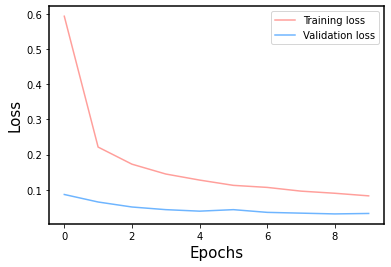

In [108]:
plt.plot(history_dict_cnn3['loss'], label='Training loss', color='#ff9f9b')
plt.plot(history_dict_cnn3['val_loss'], label='Validation loss', color='#6eb5ff')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('images/CNN3_loss.png')
plt.show()

In [105]:
results_cnn3 = model_cnn3.evaluate(MNIST_test_X, MNIST_test_y)

313/313 [==============================] - 2s 5ms/step - loss: 0.0220 - accuracy: 0.9930


##Retraining model on FASHION MNIST data

In [109]:
epochs = 30
batch_size = 64

In [111]:
history_cnn4 = model_cnn3.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val, y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                               callbacks=[learning_rate_reduction])

Epoch 1/30
703/703 [==============================] - 24s 34ms/step - loss: 0.8081 - accuracy: 0.7032 - val_loss: 0.5467 - val_accuracy: 0.7930 - lr: 1.2500e-04
Epoch 2/30
703/703 [==============================] - 21s 29ms/step - loss: 0.7212 - accuracy: 0.7328 - val_loss: 0.5047 - val_accuracy: 0.8131 - lr: 1.2500e-04
Epoch 3/30
703/703 [==============================] - 20s 28ms/step - loss: 0.6695 - accuracy: 0.7512 - val_loss: 0.4692 - val_accuracy: 0.8277 - lr: 1.2500e-04
Epoch 4/30
703/703 [==============================] - 19s 26ms/step - loss: 0.6280 - accuracy: 0.7685 - val_loss: 0.4468 - val_accuracy: 0.8340 - lr: 1.2500e-04
Epoch 5/30
703/703 [==============================] - 22s 31ms/step - loss: 0.5993 - accuracy: 0.7793 - val_loss: 0.4196 - val_accuracy: 0.8429 - lr: 1.2500e-04
Epoch 6/30
703/703 [==============================] - 19s 26ms/step - loss: 0.5715 - accuracy: 0.7892 - val_loss: 0.3998 - val_accuracy: 0.8488 - lr: 1.2500e-04
Epoch 7/30
703/703 [==============

In [112]:
history_dict_cnn4 = history_cnn4.history

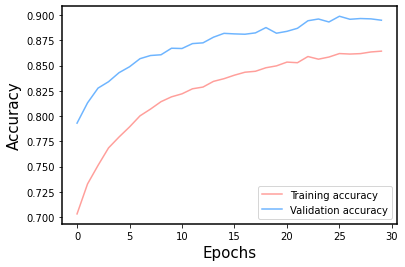

In [115]:
plt.plot(history_dict_cnn4['accuracy'], label='Training accuracy', color='#ff9f9b')
plt.plot(history_dict_cnn4['val_accuracy'], label='Validation accuracy', color='#6eb5ff')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('images/CNN4_accuracy.png')
plt.show()

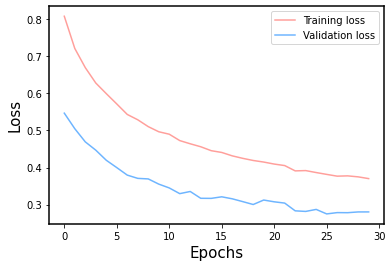

In [116]:
plt.plot(history_dict_cnn4['loss'], label='Training loss', color='#ff9f9b')
plt.plot(history_dict_cnn4['val_loss'], label='Validation loss', color='#6eb5ff')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('images/CNN4_loss.png')
plt.show()

In [117]:
results_cnn4 = model_cnn3.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2732 - accuracy: 0.8993


In [118]:
print('Test Loss : {:.4f}'.format(results_cnn4[0]))
print('Test Accuracy : {:.4f}'.format(results_cnn4[1]))

Test Loss : 0.2732
Test Accuracy : 0.8993


In [119]:
cnn4_pred = model_cnn3.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [120]:
cnn3_cm = confusion_matrix(y_test_cm, np.argmax(cnn4_pred, axis=1))

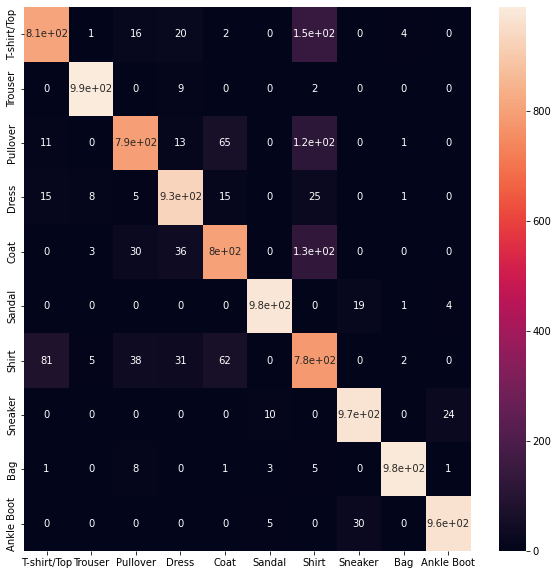

In [121]:
df_cm = pd.DataFrame(cnn3_cm, index = names,
                  columns = names)
plt.figure(figsize = (10,10))
cnn_cm_heatmap = sns.heatmap(df_cm, annot=True)
plt.savefig('images/CNN3_cm.png')

In [122]:
cnn4_pred = np.argmax(cnn4_pred, axis=1)

In [123]:
cnn4_incorrect = 0
for i in range(len(cnn4_pred)):
    if (cnn4_pred[i] != y_test_cm[i]):
        cnn4_incorrect += 1
print(cnn4_incorrect)

1007


In [124]:
incorrect = []
while len(incorrect) < 4:
    randint = np.random.randint(0,len(cnn4_pred))
    if (cnn4_pred[randint] != y_test_cm[randint]) and (randint not in incorrect):
        incorrect.append(randint)

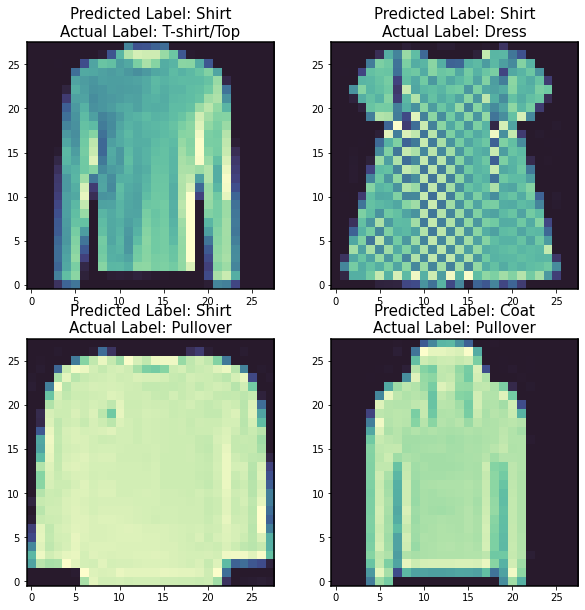

In [126]:
a = 0
fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.set_size_inches(10,10)
for i in range(4):
    r=i//2
    c=i%2
    ax[r,c].imshow(X_test[incorrect[a]].reshape(28,28))
    ax[r,c].set_title('Predicted Label: ' + names[cnn4_pred[incorrect[a]]] + '\n'+'Actual Label: ' + 
                 names[y_test_cm[incorrect[a]]])
    a+=1
plt.savefig('images/CNN4_incorrect_pred.png')

In [127]:
model_cnn.save('models/CNN3_Model')

#Summary

In [139]:
summary = pd.DataFrame(np.array(['Artifical Neural Network', results[0], results[1]*100, ann_incorrect,
                                 'Convolutional Neural Network', results_cnn[0], results_cnn[1]*100, cnn_incorrect,
                                 'Convolutional Neural Network with data generator', results_cnn2[0], results_cnn2[1]*100, cnn2_incorrect,
                                 'Pretrained Convolutional Neural Network', results_cnn4[0], results_cnn4[1]*100, cnn4_incorrect]).reshape(4,4),
                       columns=['Name', 'Loss', 'Accuracy', 'Numer of incorrect predictions'])


In [140]:
summary

,Name,Loss,Accuracy,Numer of incorrect predictions
0,Artifical Neural Network,0.30237022042274475,89.5900011062622,1041
1,Convolutional Neural Network,0.19216600060462952,92.86999702453613,713
2,Convolutional Neural Network with data generator,0.2698189616203308,90.10999798774719,989
3,Pretrained Convolutional Neural Network,0.27321791648864746,89.92999792098999,1007



The best model turned out to be the standard CNN with almost 93% accuracy. The CNN model with the data generator performed worse, but it may need more training to beat the standard CNN model with accuracy. In the same way, the CNN pre-training model can be better if we spend more time on training. However, the main goal of the project was to show the differences between individual neural networks, which differ only in individual training techniques.

Below is a more detailed model comparison which includes:

* Precision is the ability of a classiifer not to label an instance positive that is actually negative. Basically, it is defined as the ratio of true positives to the sum of true and false positives. 

* Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.

* The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0 . Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation.

* Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing.

In [131]:
print('ANN classification raport:\n\n', classification_report(y_test_cm, ann_pred, target_names = names))

ANN classification raport:

               precision    recall  f1-score   support

 T-shirt/Top       0.82      0.86      0.84      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.84      0.81      0.82      1000
       Dress       0.91      0.91      0.91      1000
        Coat       0.82      0.86      0.84      1000
      Sandal       0.98      0.95      0.97      1000
       Shirt       0.73      0.69      0.71      1000
     Sneaker       0.93      0.96      0.94      1000
         Bag       0.98      0.97      0.98      1000
  Ankle Boot       0.96      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [132]:
print('CNN classification raport:\n\n', classification_report(y_test_cm, cnn_pred, target_names = names))

CNN classification raport:

               precision    recall  f1-score   support

 T-shirt/Top       0.86      0.90      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.90      0.90      0.90      1000
       Dress       0.92      0.94      0.93      1000
        Coat       0.90      0.88      0.89      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.82      0.77      0.79      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag       0.99      0.99      0.99      1000
  Ankle Boot       0.96      0.98      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [133]:
print('CNN with data generator classification raport:\n\n', classification_report(y_test_cm, cnn2_pred, target_names = names))

CNN with data generator classification raport:

               precision    recall  f1-score   support

 T-shirt/Top       0.85      0.85      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.89      0.82      0.86      1000
       Dress       0.89      0.94      0.91      1000
        Coat       0.84      0.81      0.82      1000
      Sandal       0.99      0.96      0.98      1000
       Shirt       0.69      0.73      0.71      1000
     Sneaker       0.93      0.98      0.96      1000
         Bag       0.97      0.99      0.98      1000
  Ankle Boot       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [135]:
print('Pretrained CNN with data generator classification raport:\n\n', classification_report(y_test_cm, cnn4_pred, target_names = names))

Pretrained CNN with data generator classification raport:

               precision    recall  f1-score   support

 T-shirt/Top       0.88      0.81      0.85      1000
     Trouser       0.98      0.99      0.99      1000
    Pullover       0.89      0.79      0.84      1000
       Dress       0.90      0.93      0.91      1000
        Coat       0.85      0.80      0.82      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.65      0.78      0.71      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.99      0.98      0.99      1000
  Ankle Boot       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



#Download form Colab

In [136]:
!zip -r /content/file.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2023.03.27/ (stored 0%)
  adding: content/.config/logs/2023.03.27/13.39.06.537398.log (deflated 91%)
  adding: content/.config/logs/2023.03.27/13.40.54.152121.log (deflated 56%)
  adding: content/.config/logs/2023.03.27/13.40.21.054430.log (deflated 58%)
  adding: content/.config/logs/2023.03.27/13.40.05.789778.log (deflated 86%)
  adding: content/.config/logs/2023.03.27/13.40.53.271712.log (deflated 57%)
  adding: content/.config/logs/2023.03.27/13.39.37.349339.log (deflated 58%)
  adding: content/.con

In [138]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>